In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.animation as animation
import time
import struct
import tensorflow as tf
import random as rd

from array import array
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

# my project
from module.conf import PROJECT_DIR

# %matplotlib tk
%matplotlib inline


1. Load data:
- Train data: 60k 28x28 images
- Test data: 

In [3]:
mnist_path = "/data/sample/mnist"
training_images_filepath = "".join([PROJECT_DIR, mnist_path, "/train-images.idx3-ubyte"])
training_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/train-labels.idx1-ubyte"])
test_images_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-images.idx3-ubyte"])
test_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-labels.idx1-ubyte"])

def read_images_labels(images_filepath, labels_filepath) -> tuple:
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        # labels = array("B", file.read())
        labels = array("B", file.read())

    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())       
     
    images = []
    # for i in range(size):
    #     images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        # images[i][:] = img
        images.append(img)
    
    return images, labels

def load_data() -> tuple:
    x_train, y_train = read_images_labels(training_images_filepath, training_labels_filepath)
    x_test, y_test = read_images_labels(test_images_filepath, test_labels_filepath)
    return (x_train, y_train),(x_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data()

In [4]:
# print(f"{type(X_train[0])}")
# mnist = tf.keras.datasets.mnist

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# X_train


In [5]:
X_train = np.asarray(X_train)/255
y_train = np.asarray(y_train)
X_test  = np.asarray(X_test)/255
y_test  = np.asarray(y_test)

2. Build model

In [6]:
model: tf.keras.models.Model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Flatten(input_shape=(28, 28,)),
    # tf.keras.layers.Dense(units=25, activation=tf.keras.activations.relu),
    # tf.keras.layers.Dense(units=15, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu),
    # tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.linear)
])

3. Fit the model

In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives()])
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
              loss=loss_fn,
              metrics=["accuracy", "mae"])

In [9]:
# X_train, X_test = np.asarray(X_train) / 255.0, np.asarray(X_test) / 255.0
print(X_train.shape)

# model.fit(X_train, y_train, epochs=24, batch_size=6000)

(60000, 28, 28)


4. Test the model

In [7]:
model.evaluate(X_test,  y_test, verbose=2)
c = 0
cp = 0
for i in range(100):
    test_indx = rd.randint(0, len(y_test)-1)
    x_test_ = np.asarray([X_test[test_indx]])

    # test_indx = rd.randint(0, len(y_train)-1)
    # x_test_ = np.asarray([X_train[test_indx]])

    result = model.predict(x=x_test_, verbose=0)
    result = tf.nn.softmax(result).numpy()
    y_test_ = y_test
    if result.max() >= 0.5:
        if result.argmax() != y_test_[test_indx]:
            c+=1
            print(f"- [{i}]:img[{test_indx}]:{result}\npred:{result.max()}\npredict:{result.argmax()} solve:{y_test_[test_indx]}")
    else:
        print(f"can not predict:{test_indx}: {result.max()}")
        cp+=1
print(f"error: {c} can not pred:{cp}")

313/313 - 2s - loss: 0.2706 - accuracy: 0.9253 - mae: 5.7893 - 2s/epoch - 5ms/step
can not predict:3136: 0.34409135580062866
- [7]:img[3436]:[[1.67532289e-05 5.67955136e-01 1.51821613e-01 1.01415925e-02
  2.97620404e-03 1.92857552e-02 5.20323217e-02 1.23961411e-01
  6.20248057e-02 9.78442933e-03]]
pred:0.5679551362991333
predict:1 solve:2
- [8]:img[1901]:[[3.4738739e-05 1.8349192e-04 4.5578633e-03 3.1608408e-03 8.2679886e-01
  3.3020590e-02 6.9132992e-03 9.0115092e-04 6.8897292e-02 5.5531837e-02]]
pred:0.8267988562583923
predict:4 solve:9
can not predict:1128: 0.3912167251110077
- [18]:img[1981]:[[4.2353950e-05 3.7868874e-04 1.0734836e-02 2.1206947e-04 8.0766791e-01
  4.4138628e-04 1.4424849e-01 3.7029688e-04 7.3830611e-03 2.8520858e-02]]
pred:0.8076679110527039
predict:4 solve:6
can not predict:4640: 0.3267766237258911
- [53]:img[4256]:[[1.5969522e-01 2.7626791e-07 5.2001953e-01 3.1909066e-01 4.2778967e-09
  2.5060418e-04 8.4739580e-04 5.9816321e-05 3.3820888e-05 2.6491678e-06]]
pred:

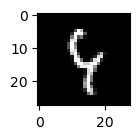

In [16]:
def show_image(img_data: np.ndarray) -> tuple:
    fig, axes = plt.subplots(figsize=(1.60, 1.20))
    axes.imshow(X=img_data, cmap="gray")
    return fig, axes

# print(y_test[5854])
show_image(X_test[1901])
plt.show()

In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

Num GPUs Available:  1
